In [1]:
pip install photutils

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 4.3 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
## Import necessary modules

from astropy.io import fits
from astropy.wcs import WCS
from astropy.stats import sigma_clipped_stats
import glob
import os
import subprocess
import warnings
import numpy as np
import matplotlib.pyplot as plt
import photutils
import math
from scipy import ndimage

In [4]:
def test_dependency(dep, alternate_name=None):
    try:
        subprocess.check_output(dep, stderr=subprocess.PIPE, shell=True)
        print("%s is installed properly as %s. OK" % (dep, dep))
        return 1
    except subprocess.CalledProcessError:
        try:
            subprocess.check_output(alternate_name, stderr=subprocess.PIPE, shell=True)
            print("%s is installed properly as %s. OK" % (dep, alternate_name))
            return 1
        except subprocess.CalledProcessError:
            print("===%s/%s IS NOT YET INSTALLED PROPERLY===" % (dep, alternate_name))
            return 0

In [5]:
dependencies = [('source-extractor', 'sex'), ('SWarp', 'swarp')]
i = 0
for dep_name1, dep_name2 in dependencies:
    i += test_dependency(dep_name1, dep_name2)
print("%i out of %i external dependencies installed properly.\n" % (i, len(dependencies)))
if i != len(dependencies):
    print("Please correctly install these programs before continuing by following the instructions in README.md.")
else:
    print("You are ready to continue.")

===source-extractor/sex IS NOT YET INSTALLED PROPERLY===
===SWarp/swarp IS NOT YET INSTALLED PROPERLY===
0 out of 2 external dependencies installed properly.

Please correctly install these programs before continuing by following the instructions in README.md.


In [6]:
## Define data directories
def get_data_directories():
  curpath = os.path.abspath('.')                    # top level directory
  dataFolder = os.path.join(curpath,'/content')         #data directory
  biasFolder = os.path.join(dataFolder,input('Enter the path to bias files ') )# bias frames subdirectory
  flatFolder = os.path.join(dataFolder,input('Enter the path to flat files ') )# flat fields subdirectory
  sciFolder = os.path.join(dataFolder,input('Enter the path to science files '))# science data subdirectory
  procFolder = os.path.join(curpath,input('Enter the path to proc dictionary '))  # processing directory
  if not os.path.isdir(procFolder):
     os.mkdir(procFolder)
  else:
     for f in os.listdir(procFolder):
          try:
              os.remove(os.path.join(procFolder,f)) # clear the processing folder from previous iterations
          except:
              print('Could not remove',f)
  ## Get file lists
  os.chdir(sciFolder)
  fileList = sorted(glob.glob('*.fits'))
  os.chdir(curpath)
  biasList = sorted(glob.glob(os.path.join(biasFolder,'*.fits')))
  flatList = sorted(glob.glob(os.path.join(flatFolder,'*.fits')))
  sciList = [os.path.join(sciFolder, file) for file in fileList]
  procList = [os.path.join(procFolder, file).replace('.fits','.proc.fits') for file in fileList]
  combinedFile = os.path.join(procFolder, 'AT2018cow_combined.fits')
  weightFile = os.path.join(procFolder, 'AT2018cow_weight.fits')
  resampledFile = os.path.join(procFolder, 'AT2018cow_resampled.fits')
  print('Found',len(biasList),'bias files; ',len(flatList),'flat files; ',len(sciList),'science files')
  warnings.filterwarnings("ignore")
  return biasList, flatList, sciList, procList, combinedFile, weightFile, resampledFile
biasList, flatList, sciList, procList, combinedFile, weightFile, resampledFile = get_data_directories()

Enter the path to bias files drive/My Drive/SN2023xif/Trial/bias
Enter the path to flat files drive/My Drive/SN2023xif/Trial/flat
Enter the path to science files drive/My Drive/SN2023xif/Trial/science
Enter the path to proc dictionary drive/My Drive/SN2023xif/Trial/proc
Found 5 bias files;  5 flat files;  3 science files


In [7]:

## Open an example FITS file
exampleFile = sciList[0]         # The first science image
HDUList = fits.open(exampleFile) # Open the file
HDUList.info()                   # Print some information about the FITS file structure.

Filename: /content/drive/My Drive/SN2023xif/Trial/science/acam761.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     139   ()      
  1  extension1    1 ImageHDU        49   (2148, 2501)   int16 (rescales to uint16)   


In [8]:

## Print some header properties

header = HDUList[0].header # Get the header out of the HDU list.
print(repr(header[0:13]))  # Print the first 14 lines of the header (in raw format).
print(repr(header[24:34])) # Print some additional lines
print(repr(header[48:52]))
print(repr(header[67:71]))
print(repr(header[129:135]))
print()


SIMPLE  =                    T /                                                
BITPIX  =                    8 /                                                
NAXIS   =                    0 /                                                
EXTEND  =                    T / File contains extensions                       
RUN     =              2696761 / Run number                                     
IRAFNAME= 'r2696761          ' / IRAF should use this name                      
RUNSET  = '1:1:2696761       ' / i:n:r => Run i of n runs starting at #r        
SYSVER  = 'S15-281           ' / Version of observing system                    
ORIGIN  = 'ING La Palma      ' / Name of observatory                            
OBSERVAT= 'LAPALMA           ' / Name of observatory (IRAF style)               
OBSERVER= 'Dan Perley        ' / Name of principal investigator                 
PROPOSAL= 'P12               ' / Code for grant of observing time               
OBJECT  = 'AT2018cow 0.0 0.0

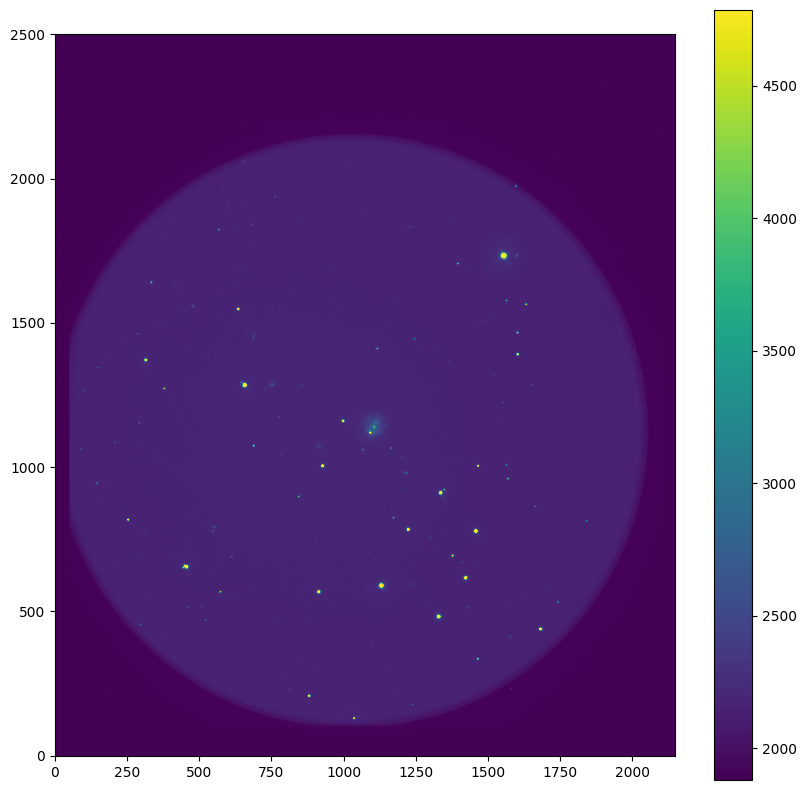

In [9]:
## Get and display the image data

data = HDUList[1].data  # Get the data array (a simple numpy array) from the first extension.

mean, median, std = sigma_clipped_stats(data) # get some image statistics
plt.figure(figsize=(10,10))                     # set up the plot panel
plt.imshow(data, vmin = median - 2*std, vmax = median + 20*std, origin='lower')
plt.colorbar()
plt.show()


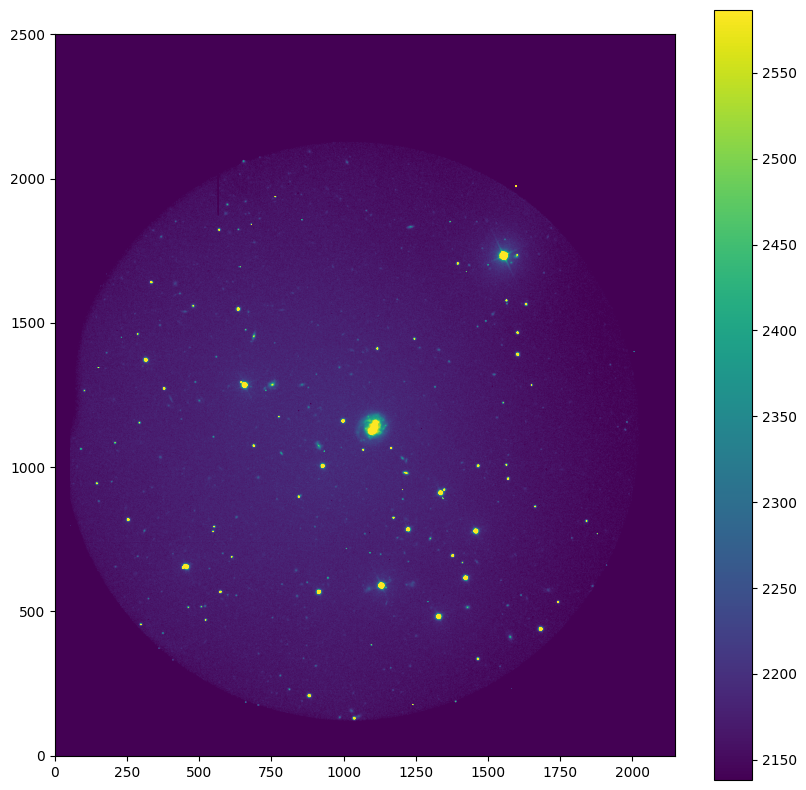

In [10]:
mean, median, std = sigma_clipped_stats(data[500:1600,500:1600]) # get some image statistics
plt.figure(figsize=(10,10))                     # set up the plot panel
plt.imshow(data, vmin = median - 2*std, vmax = median + 20*std, origin='lower')
plt.colorbar()
plt.show()


In [11]:
biasfile = biasList[0]
HDUList = fits.open(biasfile)
HDUList.info()

Filename: /content/drive/My Drive/SN2023xif/Trial/bias/acam701.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     139   ()      
  1  extension1    1 ImageHDU        49   (2148, 2501)   int16 (rescales to uint16)   


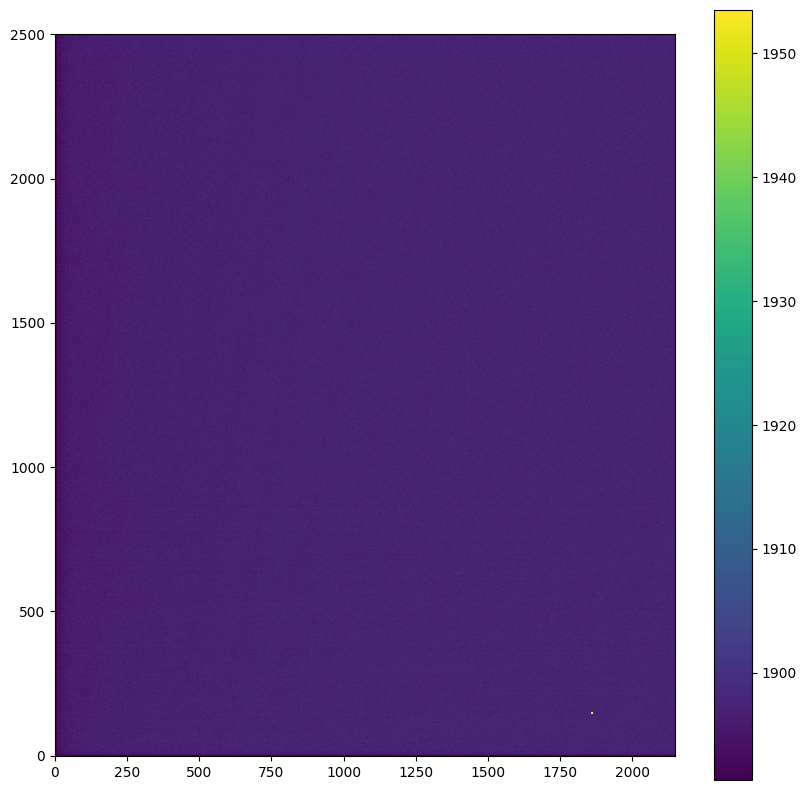

In [12]:
data = HDUList[1].data  # Get the data array (a simple numpy array) from the first extension.

mean, median, std = sigma_clipped_stats(data) # get some image statistics
plt.figure(figsize=(10,10))                     # set up the plot panel
plt.imshow(data, vmin = median - 2*std, vmax = median + 20*std, origin='lower')
plt.colorbar()
plt.show()


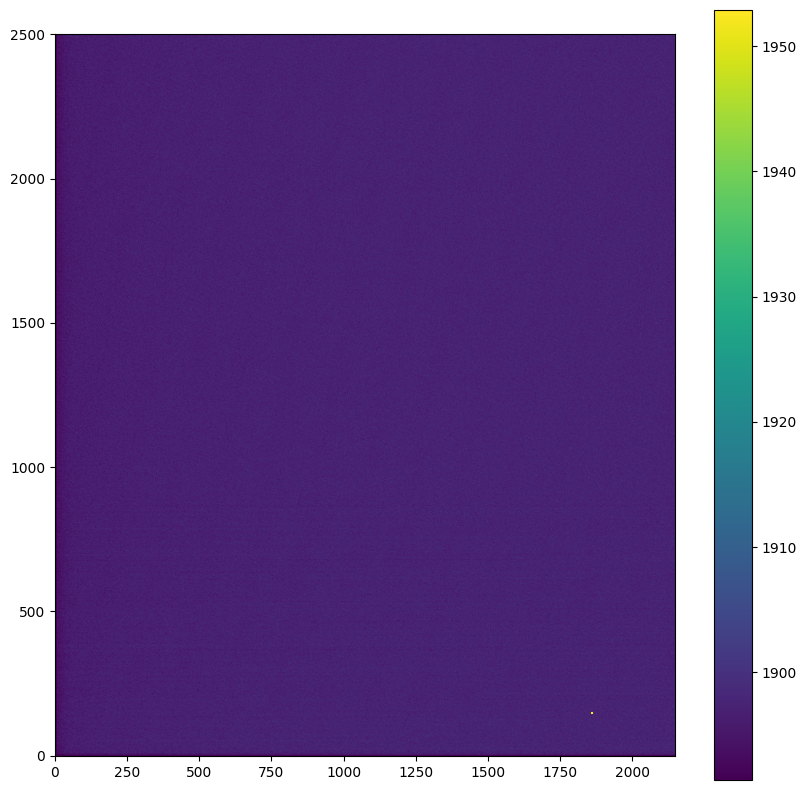

In [13]:
mean, median, std = sigma_clipped_stats(data[500:1600,500:1600]) # get some image statistics
plt.figure(figsize=(10,10))                     # set up the plot panel
plt.imshow(data, vmin = median - 2*std, vmax = median + 20*std, origin='lower')
plt.colorbar()
plt.show()

In [14]:
## Median-combine the bias frames to make a master bias

# Create a 3D array to store all the bias files together.
def masterbias(ny,nx,n):
  numBiasFiles = len(n) #length of biaslist
  biasImages = np.zeros((ny, nx, numBiasFiles))

  # Add the files to the array
  for i in range(numBiasFiles):
          HDUList = fits.open(biasList[i])     # Open the file
          biasImages[:,:,i] = HDUList[1].data  # Load the data into the appropriate layer
          HDUList.close()                      # Close the file

# Create the master bias frame by doing a median combination for each pixel over all layers
  masterBias = np.median(biasImages, axis=2)
  return masterBias

ny, nx = data.shape
masterBias = masterbias(ny, nx,biasList)

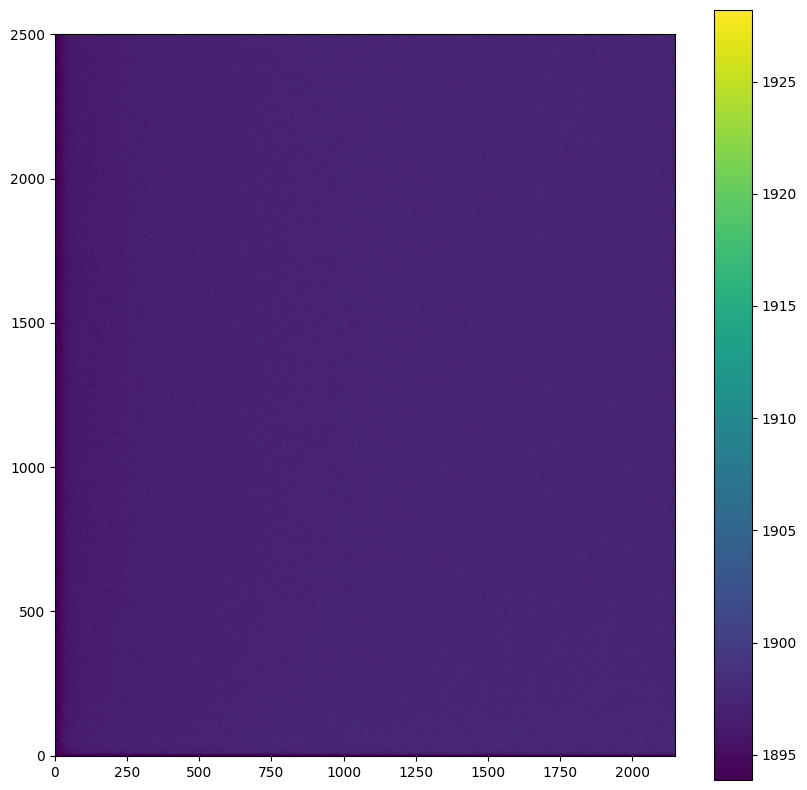

Mean = 1897.1225246167803 ,Median = 1897.0, Standard Deviation = 1.5592892457878413


In [15]:
data = masterBias.data  # Get the data array (a simple numpy array) from the first extension.

mean, median, std = sigma_clipped_stats(data) # get some image statistics
plt.figure(figsize=(10,10))                     # set up the plot panel
plt.imshow(data, vmin = median - 2*std, vmax = median + 20*std, origin='lower')
plt.colorbar()
plt.show()
print(f'Mean = {mean} ,Median = {median}, Standard Deviation = {std}')

In [16]:
flatfile = flatList[0]
HDUList = fits.open(flatfile)
HDUList.info()

Filename: /content/drive/My Drive/SN2023xif/Trial/flat/acam825.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     139   ()      
  1  extension1    1 ImageHDU        49   (2148, 2501)   int16 (rescales to uint16)   


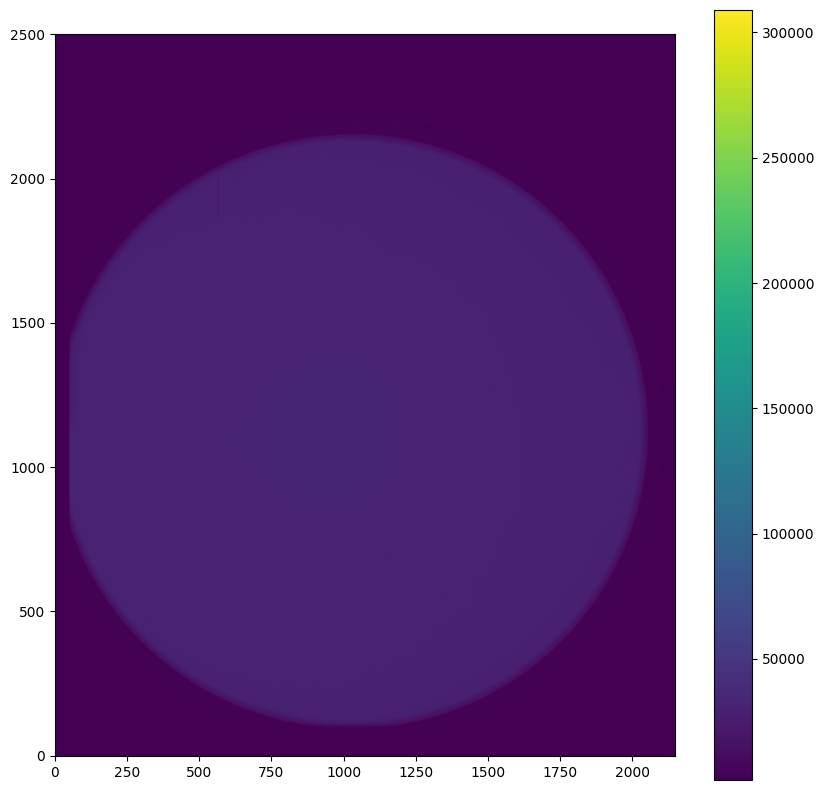

In [17]:
data = HDUList[1].data  # Get the data array (a simple numpy array) from the first extension.

mean, median, std = sigma_clipped_stats(data) # get some image statistics
plt.figure(figsize=(10,10))                     # set up the plot panel
plt.imshow(data, vmin = median - 2*std, vmax = median + 20*std, origin='lower')
plt.colorbar()
plt.show()


In [18]:
## Load and normalize the flat fields in preparation for making a master flat field.

# Set up the 3D array
def masterflat(n):
  numFlatFiles = len(n) #Length of flatfiles
  flatImages = np.zeros((ny, nx, numFlatFiles))

# Load the files into the array, with bias subtraction and normalization
  for i in range(numFlatFiles):
          # Load the data from the fits file
          HDUList = fits.open(flatList[i])
          data = HDUList[1].data * 1. # Convert to floating point
          HDUList.close()

          # Bias-subtract, normalize, and add to the array layer
          data -= masterBias
          normfactor = np.median(data[500:1600,500:1600])
          print(normfactor)
          flatImages[:,:,i] = data / normfactor

  return flatImages

flatImages = masterflat(flatList)


30237.0
30274.0
30070.0
30175.0
30097.0


In [19]:
masterFlat = np.mean(flatImages, axis=2)

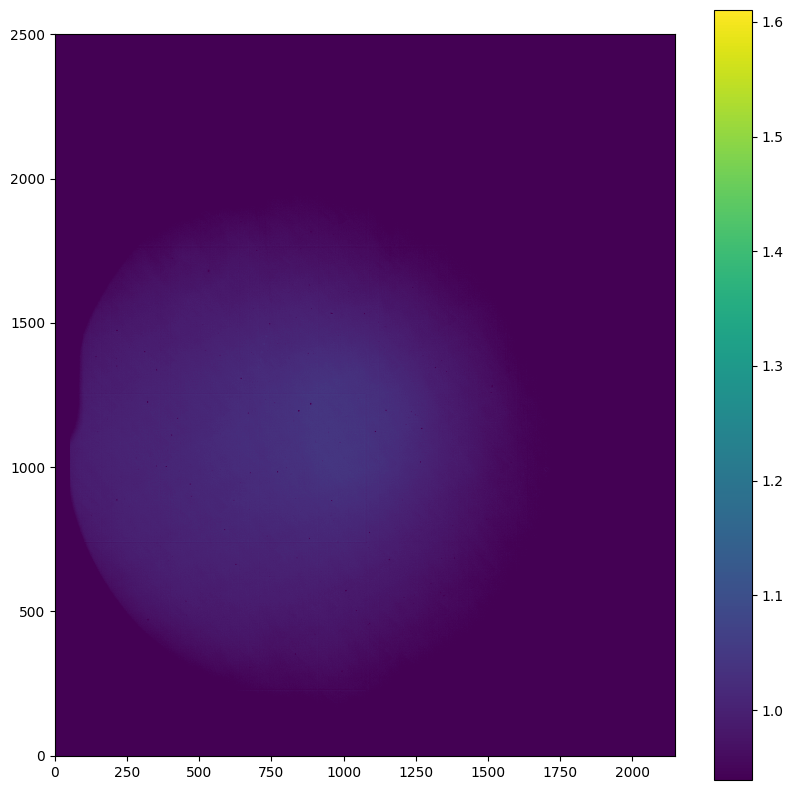

In [20]:
data = masterFlat.data  # Get the data array (a simple numpy array) from the first extension.

mean, median, std = sigma_clipped_stats(masterFlat[500:1600,500:1600]) # get some image statistics
plt.figure(figsize=(10,10))                     # set up the plot panel
plt.imshow(masterFlat, vmin = median - 2*std, vmax = median + 20*std, origin='lower')
plt.colorbar()
plt.show()

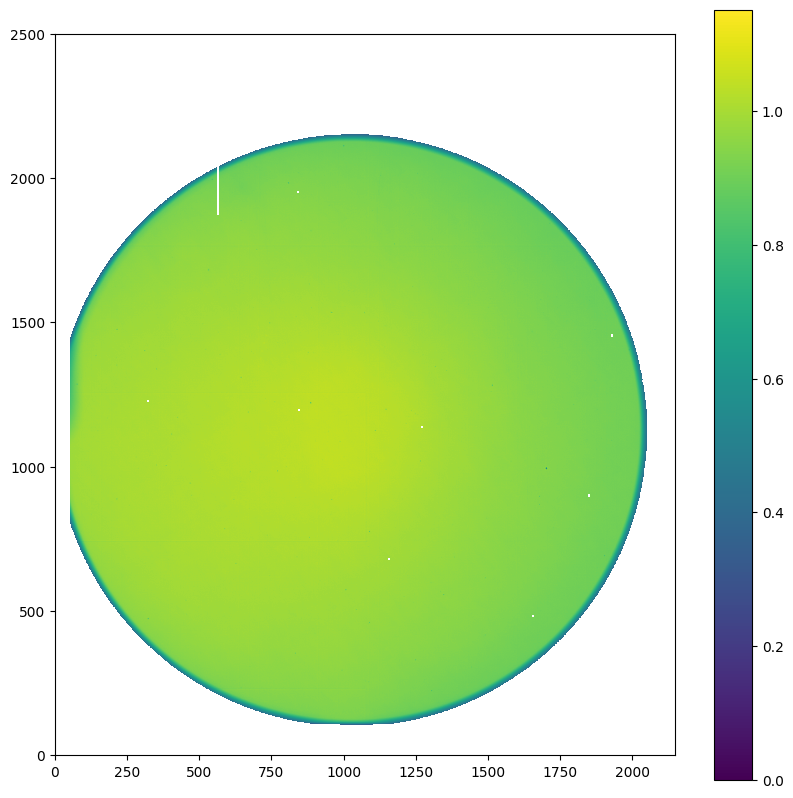

In [21]:
## Set the unexposed pixels to NaN, and display again

masterFlatFixed = np.copy(masterFlat) # Use 'copy' to preserve the original masterFlat
if np.any(masterFlat < 0.2):
        # Set all flat-field values lower than 0.2 to NaN
        masterFlatFixed[masterFlat < 0.2] = float('NaN')

plt.figure(figsize=(10,10))
#scale the image according to its statistics
plt.imshow(masterFlatFixed, vmin = 0, vmax = median + 5*std, origin='lower')
plt.colorbar()
plt.show()

In [22]:
## Bias subtract and flat-field all science frames and write out pre-processed files.

numSciFiles = len(sciList)
print('Found %d science files'%numSciFiles)

for i in range(numSciFiles):
        # Read in the FITS data.
        HDUList = fits.open(sciList[i])
        primaryHeader = HDUList[0].header
        imageData = HDUList[1].data
        HDUList.close()

        # Correct for the bias and flats here
        procData = (imageData - masterBias) / masterFlatFixed

        # Prepare the output FITS structure in simple format
        procHDU = fits.PrimaryHDU(procData)  # Create a new HDU with the processed image data
        procHDU.header = primaryHeader       # Copy over the header from the raw file
        procHDU.header.add_history('Bias corrected and flat-fielded') # Add a note to the header

        # Write the reduced frame to disk
        print(sciList[i],'->',procList[i])
        procHDU.writeto(procList[i], overwrite=True)


Found 3 science files
/content/drive/My Drive/SN2023xif/Trial/science/acam761.fits -> /content/drive/My Drive/SN2023xif/Trial/proc/acam761.proc.fits
/content/drive/My Drive/SN2023xif/Trial/science/acam762.fits -> /content/drive/My Drive/SN2023xif/Trial/proc/acam762.proc.fits
/content/drive/My Drive/SN2023xif/Trial/science/acam763.fits -> /content/drive/My Drive/SN2023xif/Trial/proc/acam763.proc.fits


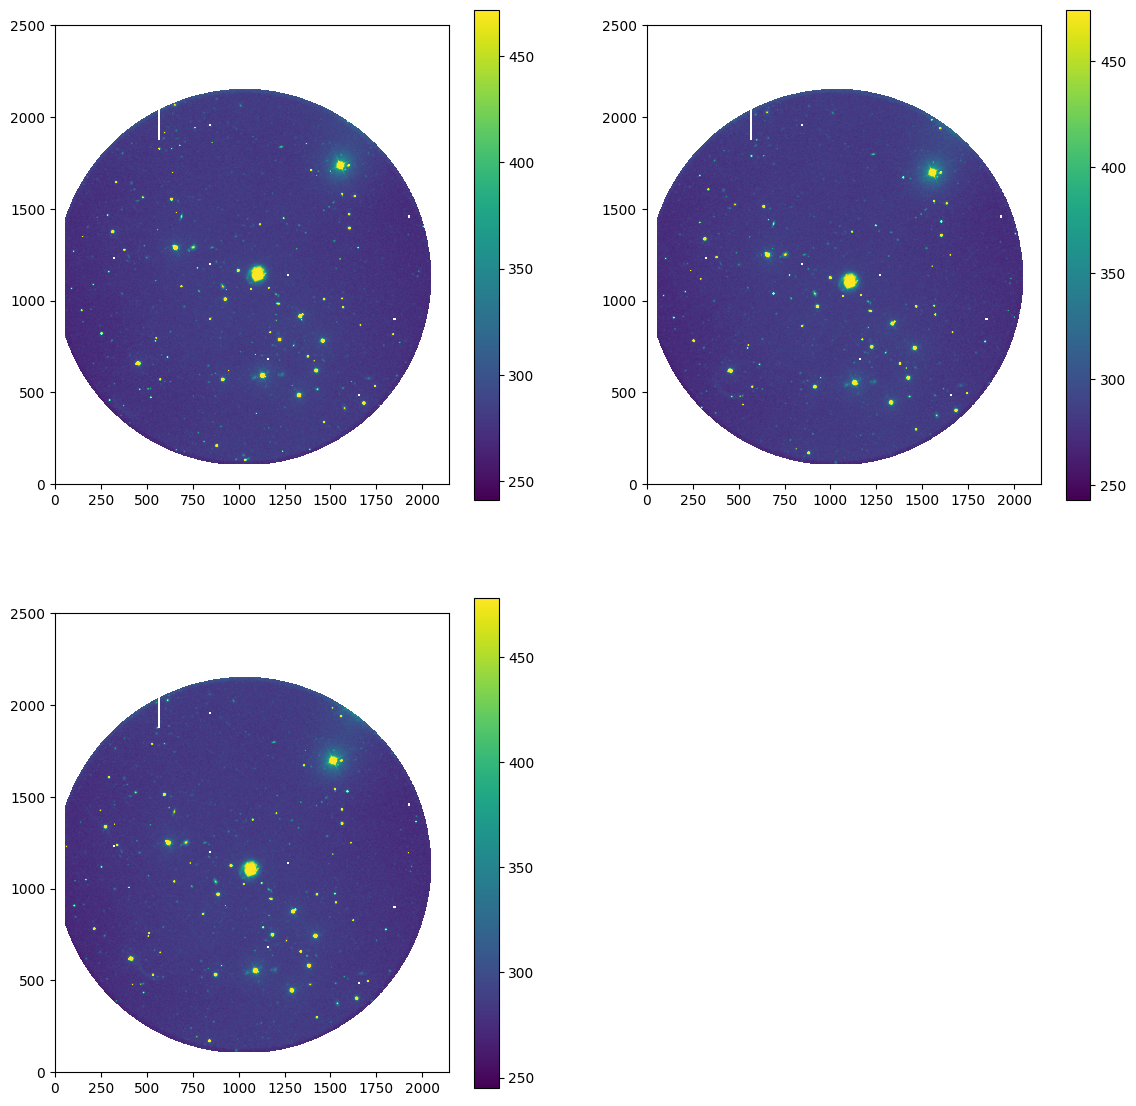

In [23]:
# Inspect the processed science files

plt.figure(figsize=(14,14))
for i in range(numSciFiles):
        procHDU = fits.open(procList[i])
        procData = procHDU[0].data
        procHDU.close()

        mean, median, std = sigma_clipped_stats(procData)
        plt.subplot(2,2,1+i)
        plt.imshow(procData, vmin = median - 2*std, vmax = median + 10*std, origin='lower')
        plt.colorbar()

In [25]:
## Define data directories
biasListg, flatListg, sciListg, procListg, combinedFileg, weightFileg, resampledFileg = get_data_directories()


Enter the path to bias files drive/My Drive/SN2023xif/bias
Enter the path to flat files drive/My Drive/SN2023xif/flat
Enter the path to science files drive/My Drive/SN2023xif/data
Enter the path to proc dictionary drive/My Drive/SN2023xif/proc
Found 14 bias files;  8 flat files;  30 science files


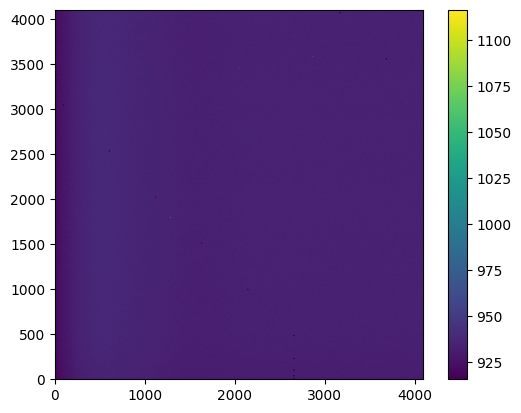

In [29]:
def bias():
  biasfileg = biasListg[0]
  HDUListg = fits.open(biasfileg)
  #HDUListg.info()
  biasdata = HDUListg[0].data  # Get the data array (a simple numpy array) from the first extension.
  return biasdata
biasdata = bias()
mean, median, std = sigma_clipped_stats(biasdata) # get some image statistics
plt.imshow(biasdata, vmin = median - 2*std, vmax = median + 20*std, origin='lower')
plt.colorbar()
plt.show()

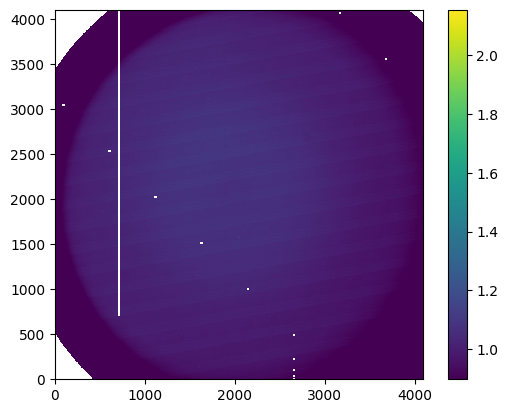

In [51]:
def flat():
  flatfileg = flatListg[0]
  HDUListg = fits.open(flatfileg)
  # HDUListg.info()  # Optional: Print file information
  flatdata = HDUListg[0].data  # Get the data array
  # Set unexposed pixels (values below 0.2) to NaN
  flatdata[flatdata < 0.2 ] = float('NaN')
  HDUListg.close()
  return flatdata  # Optional: Return the processed data (if needed)
flatdata = flat()
mean,median,std = sigma_clipped_stats(flatdata)
plt.imshow(flatdata, vmin = median - 2*std, vmax = median + 20*std, origin='lower')
plt.colorbar()
plt.show()


Found 30 science files


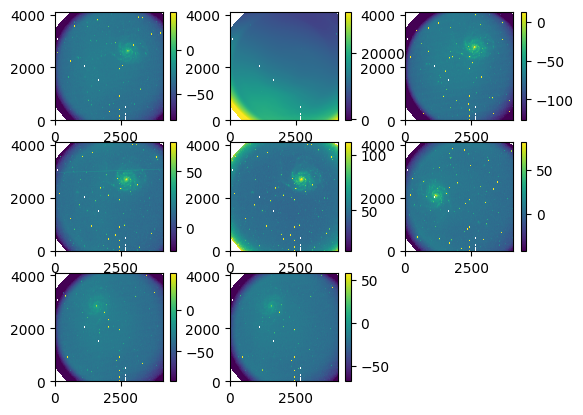

<Figure size 1000x1000 with 0 Axes>

In [55]:
numSciFiles = len(sciListg)
print('Found %d science files'%numSciFiles)

for i in range(min(numSciFiles,8)):
        # Read in the FITS data.
        HDUList = fits.open(sciListg[i])
        imageData = HDUList[0].data
        HDUList.close()
        HDUList = fits.open(biasListg[i])
        biasdata = HDUList[0].data
        HDUList.close()
        HDUList = fits.open(flatListg[i])
        flatdata = flat()
        HDUList.close()
        # Correct for the bias and flats here
        procData = (imageData - biasdata) / flatdata

        procHDU = fits.PrimaryHDU(procData)
        procHDU.writeto(procListg[i], overwrite=True)
        mean ,median, std = sigma_clipped_stats(procData)
        plt.subplot(3,3,1+i)
        plt.imshow(procData, vmin = median - 3*std, vmax = median + 5*std, origin='lower')
        plt.colorbar()
plt.figure(figsize=(10,10))
plt.show()